# Import Your Own Data
mCerebrum is not the only way to collect and load data into *Cerebral Cortex*.  It is possible to import your own structured datasets into the platform. This example will demonstrate how to load existing data and subsequently how to read it back from Cerebral Cortex through the same mechanisms you have been utilizing.  Additionally, it demonstrates how to write a custom data transformation fuction to manipulate data and produce a smoothed result which can then be visualized.

## Initialize the system

In [1]:
%reload_ext autoreload
from util.dependencies import *
from settings import USER_ID

# Import Data
Cerebral Cortex provides a set of predefined data import routines that fit typical use cases.  The most common is CSV data parser, `csv_data_parser`.  These parsers are easy to write and can be extended to support most types of data.  Additionally, the data importer, `import_data`, needs to be brought into this notebook so that we can start the data import process.

The `import_data` method requires several parameters that are discussed below.
- `cc_config`: The path to the configuration files for Cerebral Cortex; this is the same folder that you would utilize for the `Kernel` initialization
- `input_data_dir`: The path to where the data to be imported is located; in this example, `sample_data` is available in the file/folder browser on the left and you should explore the files located inside of it
- `user_id`: The universally unique identifier (UUID) that owns the data to be imported into the system
- `data_file_extension`: The type of files to be considered for import
- `data_parser`: The import method or another that defines how to interpret the data samples on a per-line basis
- `gen_report`: A simple True/False value that controls if a report is printed to the screen when complete

In [2]:
from cerebralcortex.data_importer.data_parsers import csv_data_parser
from cerebralcortex.data_importer import import_dir

import_dir(
    cc_config="/home/md2k/cc_conf/",
    input_data_dir="sample_data/",
    study_name="default",
    user_id=USER_ID,
    data_file_extension=[".csv"],
    data_parser=csv_data_parser,
    gen_report=True
)



************* IMPORTED DATA STATS *************

+---------+-------------+
|  Type   | Total Files |
+=========+=============+
| SUCCESS |      2      |
+---------+-------------+


## Create CerebralCortex object

In [3]:
CC = Kernel("/home/md2k/cc_conf/", study_name="default")

## View Imported Data

In [4]:
iot_stream = CC.get_stream("iot-data-stream")

# Data
iot_stream.show(truncate=False)

# Metadata
iot_stream.metadata

+-------------------+-------------------+--------------------+-------+------------------------------------+
|timestamp          |localtime          |some_vals           |version|user                                |
+-------------------+-------------------+--------------------+-------+------------------------------------+
|2019-01-09 17:35:00|2019-01-09 17:35:00|0.0851887269487499  |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:01|2019-01-09 17:35:01|0.16867549655743164 |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:02|2019-01-09 17:35:02|0.7404850816560419  |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:03|2019-01-09 17:35:03|0.7131609970182962  |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:04|2019-01-09 17:35:04|0.24253081438369195 |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:05|2019-01-09 17:35:05|0.2418232035246941  |1      |00000000-afb8-476e-9872-6472b4e66b68|
|2019-01-09 17:35:06|2019-01

[{
     "annotations": [],
     "data_descriptor": [
         {
             "name": "some_vals",
             "type": "double"
         }
     ],
     "description": "this is a demo iot look a like stream",
     "input_streams": [],
     "modules": [
         {
             "authors": [
                 {
                     "email": "demo@demo.com",
                     "name": "demo"
                 }
             ],
             "name": "cc_examples.import_data",
             "version": "2.0.5"
         }
     ],
     "name": "iot-data-stream"
 }]

## How to write an algorithm
This section provides an example of how to write a simple smoothing algorithm and apply it to the data that was just imported.

### Import the necessary modules

In [5]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, StringType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np

### Define the Schema
This schema defines what the computation module will return to the execution context for each row or window in the datastream.

In [6]:
schema = StructType([
    StructField("smooth_vals",  FloatType())
])

### Write a user defined function
The user-defined function (UDF) is one of two mechanisms available for distributed data processing within the Apache Spark framework.  

The `F.udf` Python decorator assigns the recently defined `schema` as a return type of the `udf` method.  The method, `smooth_algo`, accepts a list of values, `vals`, and any python-based operations can be run over this data window to produce the result defined in the schema.  In this case, we are computing a simple windowed average.

In [7]:
@F.udf(schema)
def smooth_algo(vals):
    return [sum(vals)/len(vals)]

## Run the smoothing algorithm on imported data
The smoothing algorithm is applied to the datastream by calling the `run_algorithm` method and passing the method as a parameter along with which columns, `some_vals`, that should be sent.  Finally, the `windowDuration` parameter specified the size of the time windows on which to segment the data before applying the algorithm.  Notice that when the next cell is run, the operation completes nearly instantaneously.  This is due to the lazy evaluation aspects of the Spark framework.  When you run the next cell to show the data, the algorithm will be applied to the whole dataset before displaying the results on the screen. 

In [8]:
smooth_stream = iot_stream.run_algorithm(smooth_algo, columnNames=["some_vals"], windowDuration=10)

In [9]:
smooth_stream.show(truncate=False)

+-------------------+------------------------------------+-------+------------------------------------------+-----------+
|timestamp          |user                                |version|window                                    |smooth_vals|
+-------------------+------------------------------------+-------+------------------------------------------+-----------+
|2019-01-09 17:46:30|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:46:30, 2019-01-09 17:46:40]|0.37378517 |
|2019-01-09 17:39:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:39:00, 2019-01-09 17:39:10]|0.38799626 |
|2019-01-09 17:51:10|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:51:10, 2019-01-09 17:51:20]|0.6942901  |
|2019-01-09 17:44:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:44:00, 2019-01-09 17:44:10]|0.36333913 |
|2019-01-09 17:46:00|00000000-afb8-476e-9872-6472b4e66b68|1      |[2019-01-09 17:46:00, 2019-01-09 17:46:10]|0.49662432 |
|2019-01-09 17:38:30|000

## Visualize data
These are two plots that show the original and smoothed data to visually check how the algorithm transformed the data.

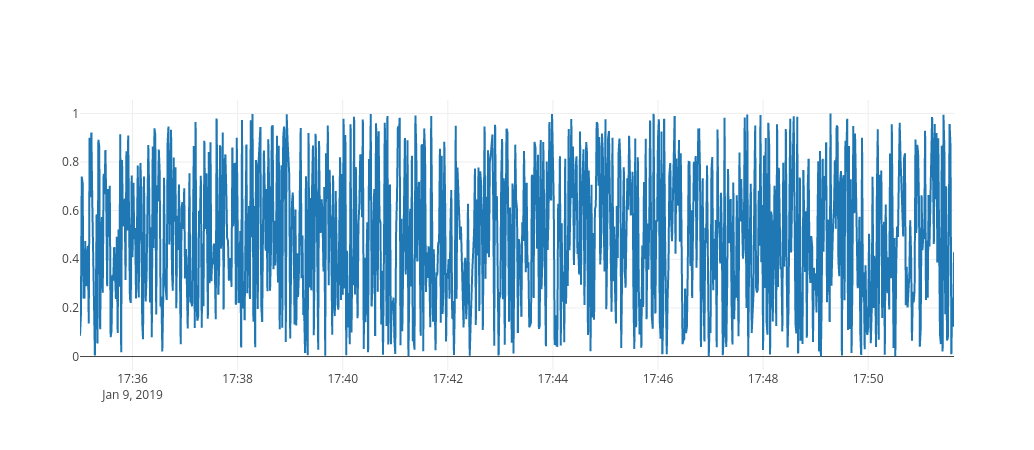

In [10]:
iot_stream.plot()

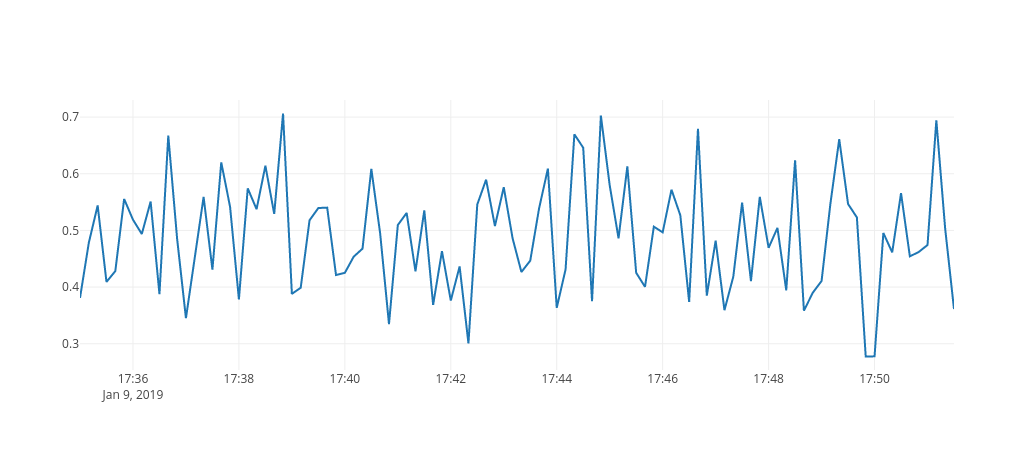

In [11]:
smooth_stream.plot()